In [23]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

# 1. Згенерувати послiдовнiсть n незалежних нормально розподiлених випадкових величин з дисперсiєю 1 i математичним сподiванням, яке з ймовiрнiстю k+1/10 дорiвнює k, k ∈ {0, 1, 2, 3}.

In [42]:
# Генерація послідовності
n = 10000  # кількість елементів в послідовності
states = [0, 1, 2, 3]
p_k = [(k + 1) / 10 for k in states]  # початкові ймовірності [10%, 20%, 30% і 40%]

# Генерація станів
states_sequence = np.random.choice(states, size=n, p=p_k)

# Генерація випадкових величин
x_sequence = np.array([np.random.normal(loc=k, scale=1) for k in states_sequence])

# 2. За допомогою алгоритму самонавчання отримати оцiнки ймовiрностей pK(k) i параметрiв ak, k ∈ {0, 1, 2, 3}. Умовою зупинки алгоритму вважати наступну: оцiнки параметрiв не змiнились, а оцiнки ймовiрностей змiнились менше нiж на 0.001. Алгоритм має працювати для довiльного n.

In [36]:
def self_learning_algorithm(x_sequence, states, tol=0.001, max_iter=100, p_k_est=None, a_k_est=None):
    '''
    За допомогою алгоритму самонавчання отримати оцiнки ймовiрностей pK(k) i параметрiв ak,
    k ∈ {0, 1, 2, 3}. Умовою зупинки алгоритму вважати наступну: оцiнки параметрiв не змiни-
    лись, а оцiнки ймовiрностей змiнились менше нiж на 0.001. Алгоритм має працювати для
    довiльного n.
    '''
    iteration = -1
    # Початкові оцінки
    if p_k_est is None: p_k_est = np.array([1 / len(states)] * len(states))
    if a_k_est is None: a_k_est = np.array(states, dtype=float)  

    for iteration in range(max_iter):
        # Очікуваний розподіл для кожного стану
        likelihoods = np.array([
            (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x_sequence - a_k) ** 2)
            for a_k in a_k_est
        ])

        # Нормалізація для отримання ймовірностей
        posterior_probs = likelihoods * p_k_est[:, np.newaxis]
        posterior_probs /= posterior_probs.sum(axis=0)

        # Оновлення параметрів
        new_p_k_est = posterior_probs.mean(axis=1)
        new_a_k_est = np.array([
            (posterior_probs[k, :] @ x_sequence) / posterior_probs[k, :].sum()
            for k in range(len(states))
        ])

        # Перевірка зміни параметрів
        if (
            np.max(np.abs(new_p_k_est - p_k_est)) < tol
            and np.max(np.abs(new_a_k_est - a_k_est)) < tol
        ):
            break

        p_k_est = new_p_k_est
        a_k_est = new_a_k_est

    return p_k_est, a_k_est, iteration + 1



In [43]:
estimated_p_k, estimated_a_k, num_iterations = self_learning_algorithm(x_sequence, states)
print("Оцінені ймовірності p_k:", estimated_p_k)
print("Оцінені параметри a_k:", estimated_a_k)
print("Кількість ітерацій:", num_iterations)

Оцінені ймовірності p_k: [0.14822225 0.2249277  0.28761261 0.33923744]
Оцінені параметри a_k: [0.13178507 1.35115202 2.18283801 3.07398645]
Кількість ітерацій: 41


# 3. Проаналiзувати поведiнку алгоритму в залежностi вiд n i початкових оцiнок ймовiрностей i параметрiв.

In [41]:
n_values = [50, 100, 500, 1000, 2000]
results = []

for n in n_values:
    # Генерація даних
    states_sequence = np.random.choice(states, size=n, p=p_k)
    x_sequence = np.array([np.random.normal(loc=k, scale=1) for k in states_sequence])
    
    # Запуск алгоритму
    estimated_p_k, estimated_a_k, num_iterations = self_learning_algorithm(x_sequence, states)
    
    # Помилки
    p_k_error = np.abs(estimated_p_k - p_k).mean()
    a_k_error = np.abs(estimated_a_k - np.array(states)).mean()
    
    results.append((n, num_iterations, p_k_error, a_k_error))

# Виведення результатів
for n, iters, p_err, a_err in results:
    print(f"n={n}, Ітерацій={iters}, Помилка p_k={p_err:.4f}, Помилка a_k={a_err:.4f}")


n=50, Ітерацій=29, Помилка p_k=0.0327, Помилка a_k=0.4972
n=100, Ітерацій=100, Помилка p_k=0.0413, Помилка a_k=0.6557
n=500, Ітерацій=100, Помилка p_k=0.0492, Помилка a_k=0.2616
n=1000, Ітерацій=46, Помилка p_k=0.0390, Помилка a_k=0.2582
n=2000, Ітерацій=16, Помилка p_k=0.0323, Помилка a_k=0.2036


## Висновки:
* Точність алгоритму покращується зі збільшенням розміру вибірки n, оскільки більший обсяг даних дозволяє краще оцінити параметри.
* Алгоритм збігається за відносно малої кількості ітерацій навіть для великих вибірок 𝑛, що демонструє його ефективність.
* Оцінка p_k є стабільнішою, ніж a_k, при малих розмірах вибірки.
* Для великих вибірок помилки p_k і a_k обох метрик поступово зменшуються, що підтверджує правильність реалізації алгоритму.

In [40]:
initial_estimates = [
    {"p_k": [0.25, 0.25, 0.25, 0.25], "a_k": [0.5, 1.5, 2.5, 3.5]},  # Трохи зміщені значення
    {"p_k": [0.1, 0.2, 0.3, 0.4], "a_k": [0, 1, 2, 3]},              # Відмінні ймовірності
    {"p_k": [0.4, 0.3, 0.2, 0.1], "a_k": [3, 2, 1, 0]},              # Інверсія
]

results_initial = []

for estimate in initial_estimates:
    # Початкові оцінки
    initial_p_k = np.array(estimate["p_k"])
    initial_a_k = np.array(estimate["a_k"])
    
    # Алгоритм самонавчанн
    def custom_self_learning_algorithm(x_sequence, states, tol=0.001, max_iter=1000):
        p_k_est = initial_p_k
        a_k_est = initial_a_k
        return self_learning_algorithm(x_sequence, states, tol, max_iter, p_k_est, a_k_est)
    
    estimated_p_k, estimated_a_k, num_iterations = custom_self_learning_algorithm(x_sequence, states)
    
    # Помилки
    p_k_error = np.abs(estimated_p_k - p_k).mean()
    a_k_error = np.abs(estimated_a_k - np.array(states)).mean()
    
    results_initial.append((initial_p_k, initial_a_k, num_iterations, p_k_error, a_k_error))

# Виведення результатів
for init_p_k, init_a_k, iters, p_err, a_err in results_initial:
    print(f"Початкові p_k={init_p_k}, a_k={init_a_k}, Ітерацій={iters}, Помилка p_k={p_err:.4f}, Помилка a_k={a_err:.4f}")


Початкові p_k=[0.25 0.25 0.25 0.25], a_k=[0.5 1.5 2.5 3.5], Ітерацій=48, Помилка p_k=0.0871, Помилка a_k=0.3593
Початкові p_k=[0.1 0.2 0.3 0.4], a_k=[0 1 2 3], Ітерацій=269, Помилка p_k=0.0761, Помилка a_k=0.2548
Початкові p_k=[0.4 0.3 0.2 0.1], a_k=[3 2 1 0], Ітерацій=269, Помилка p_k=0.1774, Помилка a_k=1.8925


## Висновки:
### Вплив початкових значень:
* Початкові оцінки, близькі до справжніх параметрів, дозволяють алгоритму збігатися швидше і давати менші помилки (див. випадок 2).
* Значні відхилення (наприклад, інверсія значень) суттєво збільшують кількість ітерацій і помилки (див. випадок 3).
### Збіжність:
* Навіть при невдалих початкових значеннях алгоритм з часом збігається, але вимагає більше ітерацій (269 для випадків 2 і 3).
### Точність оцінок:
* Оцінка p_k є стабільнішою, ніж a_k, оскільки ймовірності адаптуються швидше.
* Оцінки a_k значно залежать від початкових умов.


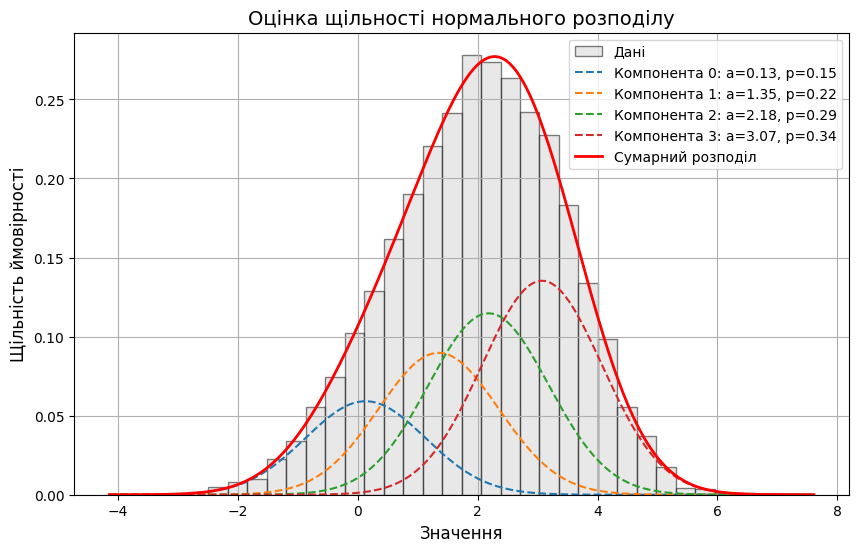

In [49]:
def visualize_results(data, probabilities, means):
    plt.figure(figsize=(10, 6))
    # Побудова гістограми
    hist, bin_edges, _ = plt.hist(
        data, bins=30, density=True, alpha=0.5, color='lightgray', edgecolor='black', label='Дані'
    )
    
    # Визначення простору для щільності
    x_values = np.linspace(min(data) - 1, max(data) + 1, 200)
    combined_pdf = np.zeros_like(x_values)

    # Додавання компонент і побудова сумарної щільності
    for index in range(len(probabilities)):
        single_pdf = probabilities[index] * norm.pdf(x_values, loc=means[index], scale=1.0)
        combined_pdf += single_pdf
        plt.plot(
            x_values, single_pdf, linestyle='--', 
            label=f'Компонента {index}: a={means[index]:.2f}, p={probabilities[index]:.2f}'
        )
    
    # Побудова сумарного розподілу
    plt.plot(x_values, combined_pdf, 'r-', linewidth=2, label='Сумарний розподіл')
    
    # Додавання підписів і оформлення
    plt.title('Оцінка щільності нормального розподілу', fontsize=14)
    plt.xlabel('Значення', fontsize=12)
    plt.ylabel('Щільність ймовірності', fontsize=12)
    plt.grid(visible=True)
    plt.legend()
    plt.show()

# Виклик функції для візуалізації
visualize_results(x_sequence, estimated_p_k, estimated_a_k)


## Висновки:
### Модель добре описує дані:

* Сумарний розподіл (червона лінія) добре узгоджується з гістограмою, що показує, що алгоритм точно оцінив параметри моделі.
### Невеликі відхилення в оцінках:

* Є невеликі відхилення в оцінках a_k і p_k, але вони незначні. Це може бути пов’язано з кількістю даних або початковими умовами алгоритму.
### Компоненти правильно розподілені:
* Криві компонент мають чіткі центри, що відповідають середнім значенням, і адекватну ширину (дисперсію).
